# Imports 

In [1]:
# %% Imports y configuración
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Agregar el directorio raíz al path
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), '..'))

from model_dpm.simulations.sim_mixture import multimodal_mixture_sampler
from model_dpm.utils.sistem_fun import load_config, get_data_path, get_report_path
from model_dpm.models.kernel_laplace_v1 import DPMLaplace
from model_dpm.graphics.density import plot_density_estimation
from model_dpm.graphics.diagnostic import plot_cluster_assignment, plot_cluster_densities, plot_traces
from model_dpm.graphics.app_1 import plot_density_credible_interval
from model_dpm.utils.sistem_regist import register_experiment
from model_dpm.utils.sistem_artefact import save_artifact

config=load_config()

# Configuracion

In [2]:
# %% Parámetros de ejecución
NOMBRE_EJECUCION = "kernel_laplace_005"
SIM_REAL = "simulation"
CARACTERISTICAS = "Prueba del modelo DPM con kernel laplace - datos simulados con mixture de Laplace y Normal mas agresivo"

print(f"📊 Ejecución: {NOMBRE_EJECUCION}")
print(f"📁 Tipo: {SIM_REAL}")
print(f"📝 Notas: {CARACTERISTICAS}")

# Registrar experimento
experiment_id = register_experiment(
    config=config,
    run_name=NOMBRE_EJECUCION,
    experiment_type=SIM_REAL,
    description=CARACTERISTICAS
)

# Persistir ID del experimento en la configuración en memoria
config["current_experiment"]["id"] = experiment_id
config["current_experiment"]["type"] = SIM_REAL
config["current_experiment"]["description"] = CARACTERISTICAS

📊 Ejecución: kernel_laplace_005
📁 Tipo: simulation
📝 Notas: Prueba del modelo DPM con kernel laplace - datos simulados con mixture de Laplace y Normal mas agresivo
✅ Experimento registrado: v2.0.0_kernel_laplace_005_20251223_001302
📁 Registry: C:\Users\JuanFran\Desktop\git_tesis\model_dpm\model_dpm\..\versioning\experiment_registry.md


# Simulacion 

In [3]:
##################################################
# Simulacion o data real
##################################################

# Definir los parámetros de cada componente
components = [
    {'type': 'laplace', 'loc': -3, 'scale': 0.5, 'size': 100},
    {'type': 'laplace', 'loc': 10, 'scale': 0.5, 'size': 200},
    {'type': 'normal', 'loc': -10, 'scale': 0.8, 'size': 80},
    {'type': 'normal', 'loc': 3, 'scale': 0.8, 'size': 130}
]

print("\n🎲 Generando datos simulados...")
datos_array  = multimodal_mixture_sampler(components)

print(f"✅ Datos generados: {len(datos_array)} observaciones")

# Convertir a DataFrame si es necesario
if isinstance(datos_array, np.ndarray):
    datos = pd.DataFrame({'value': datos_array})
else:
    datos = datos_array

print(f"✅ Datos generados: {len(datos)} observaciones")
print(f"📊 Estadísticas descriptivas:")
print(datos.describe())

##################################################
# Guardar datos 
##################################################
output_path = get_data_path(config, data_type=SIM_REAL, io_type="output")
output_path.mkdir(parents=True, exist_ok=True)

datos_file = output_path / f"{NOMBRE_EJECUCION}.csv"
datos.to_csv(datos_file, index=False)
print(f"\n💾 Datos guardados en: {datos_file}")


🎲 Generando datos simulados...
✅ Datos generados: 510 observaciones
✅ Datos generados: 510 observaciones
📊 Estadísticas descriptivas:
            value
count  510.000000
mean     2.560072
std      7.293680
min    -11.937342
25%     -3.001747
50%      3.321128
75%      9.889652
max     11.986082

💾 Datos guardados en: C:\Users\JuanFran\Desktop\git_tesis\model_dpm\data\simulaciones\kernel_laplace_005.csv


# DPM

In [4]:
##################################################
# Aplicar la clase del modelo
##################################################
# Inicializar 
print("\n🔧 Inicializando modelo DPM con kernel Laplace...")

# Crear instancia del modelo Laplace
model_laplace = DPMLaplace(
    y=datos['value'].values,
    H=20,                              # Truncamiento inicial
    M_prior=(2.0, 1.0),                # Prior para concentración M
    mu0_prior=(0.0, 100.0),            # Prior para μ₀
    kappa0_prior=(2.0, 1.0),           # Prior para κ₀
    a0_prior=(3.0, 1.0),               # Prior para a₀
    beta0_prior=(2.0, 1.0),            # Prior para β₀
    verbose=True
)

# Ajustar el modelo
print("🔄 Ajustando modelo Laplace con Slice Sampling...")
trace = model_laplace.run(iterations=400, burnin=50)

print("✅ Modelo Laplace ajustado exitosamente\n")

##################################################
# Guardar clase
##################################################

# Guardar trace
trace_path = save_artifact(
    config=config,
    experiment_id=experiment_id,
    artifact=trace,
    artifact_name="trace",
    data_type=SIM_REAL
)

# Guardar modelo completo
model_path = save_artifact(
    config=config,
    experiment_id=experiment_id,
    artifact=model_laplace,
    artifact_name="model",
    data_type=SIM_REAL
)

print("✅ Modelo Guardado exitosamente")




🔧 Inicializando modelo DPM con kernel Laplace...
🔄 Ajustando modelo Laplace con Slice Sampling...
Iter 100/400: K_eff=10, M=1.97, μ₀=1.30, κ₀=0.01, a₀=0.62, β₀=5.35
  [Acc: μ=0.13, b=0.72, κ=0.63, a=0.69]
Iter 200/400: K_eff=12, M=1.96, μ₀=0.50, κ₀=0.01, a₀=1.24, β₀=13.55
  [Acc: μ=0.08, b=0.79, κ=0.76, a=0.72]
Iter 300/400: K_eff=10, M=2.82, μ₀=-0.63, κ₀=0.01, a₀=0.75, β₀=5.61
  [Acc: μ=0.09, b=0.67, κ=0.69, a=0.69]
Iter 400/400: K_eff=12, M=1.39, μ₀=1.04, κ₀=0.01, a₀=0.73, β₀=6.06
  [Acc: μ=0.07, b=0.65, κ=0.73, a=0.70]
✅ Modelo Laplace ajustado exitosamente

✅ Artefacto 'trace' guardado
📁 Ruta: C:\Users\JuanFran\Desktop\git_tesis\model_dpm\artefact\simulaciones\models\v2.0.0_kernel_laplace_005_20251223_001302_trace.pkl
✅ Artefacto 'model' guardado
📁 Ruta: C:\Users\JuanFran\Desktop\git_tesis\model_dpm\artefact\simulaciones\models\v2.0.0_kernel_laplace_005_20251223_001302_model.pkl
✅ Modelo Guardado exitosamente


# Graficos 

In [5]:
##################################################
# Resultados exploratorios
##################################################

# Ultima asignación de la cadena
cluster_assignments = trace['z'][-1]

# Agregar al dataframe
datos['cluster'] = cluster_assignments

# Número de clusters efectivos
n_clusters = len(np.unique(cluster_assignments))
print(f"📈 Número de clusters encontrados: {n_clusters}")

print("\n📊 Distribución de observaciones por cluster:")
print(datos['cluster'].value_counts().sort_index())

# %% Estadísticas por cluster
print("\n📈 Estadísticas por cluster:")
cluster_stats = datos.groupby('cluster')['value'].agg(['mean', 'std', 'count'])
print(cluster_stats)

📈 Número de clusters encontrados: 12

📊 Distribución de observaciones por cluster:
cluster
0     95
1      4
2     60
3     94
4     96
5     11
6     11
7     20
8      1
9     28
10    69
11    21
Name: count, dtype: int64

📈 Estadísticas por cluster:
              mean       std  count
cluster                            
0         9.967460  0.822822     95
1        -4.686677  0.624828      4
2         2.712804  0.815782     60
3         9.942066  0.594691     94
4        -2.971400  0.669897     96
5        -9.130001  0.136837     11
6        10.973610  0.098289     11
7        -9.329336  0.815671     20
8         1.047061       NaN      1
9       -10.732564  0.369872     28
10        3.449670  0.713809     69
11       -9.849935  0.878346     21



📊 Generando gráfico de densidad...
📊 Generando gráfico de asignación de clusters...
📊 Generando gráfico de densidades por cluster...
📊 Generando gráficos de trazas...


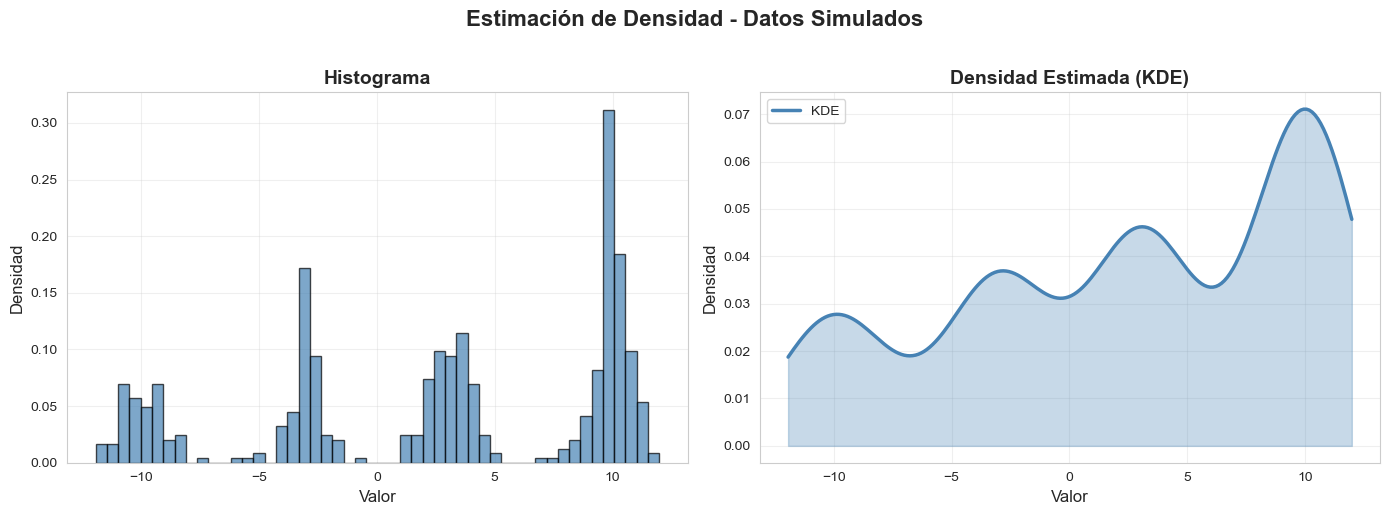

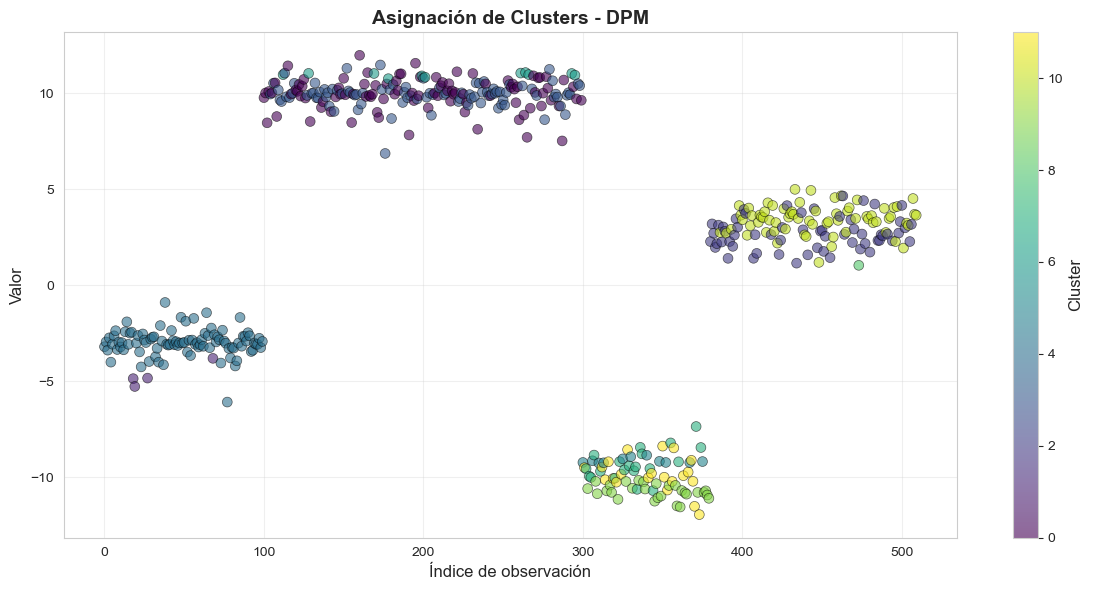

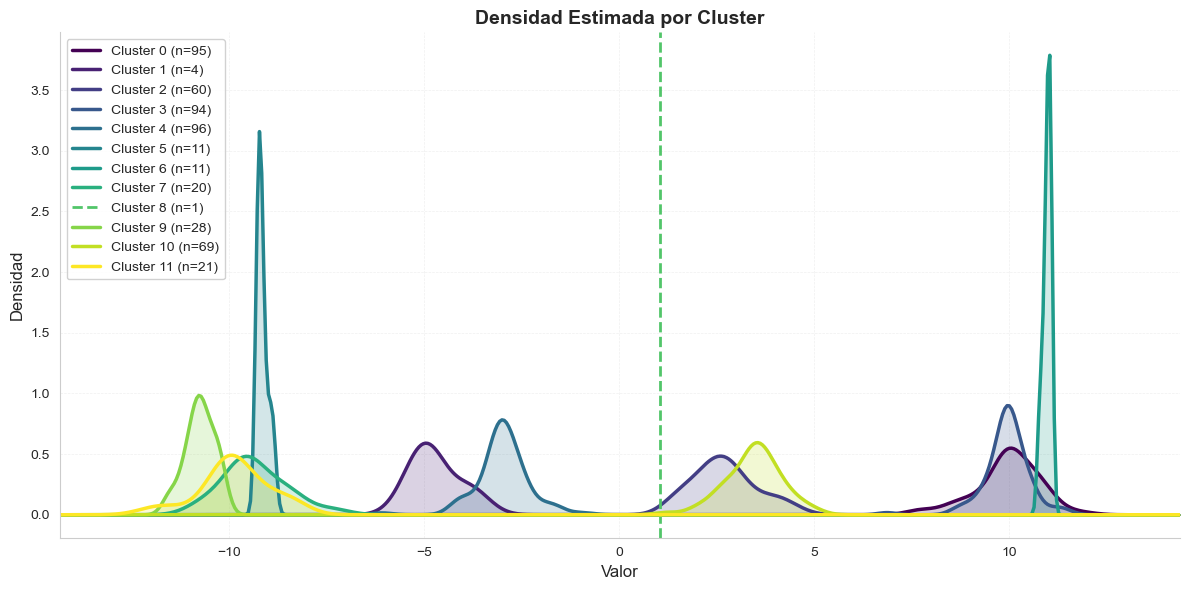

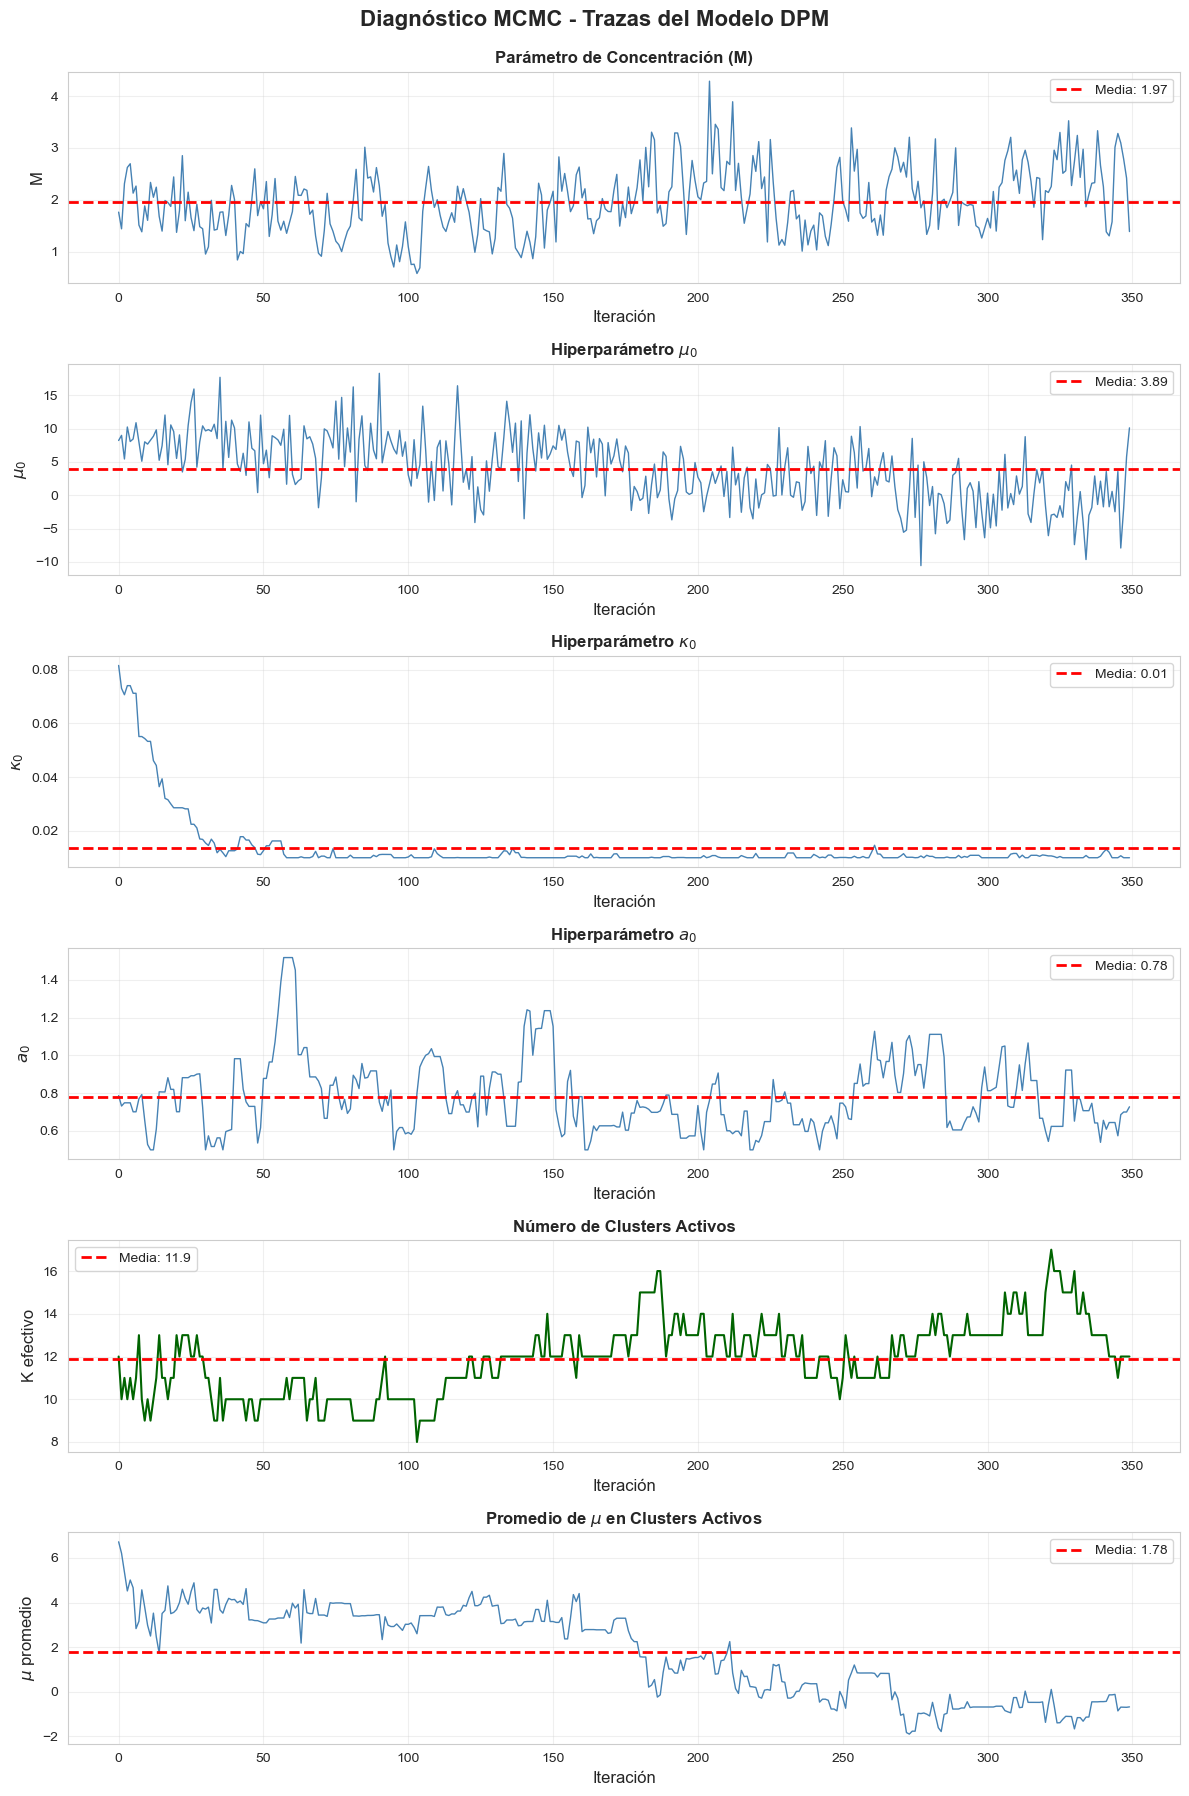

In [6]:
##################################################
# Graficos de diagnostico y analisis
##################################################

# %% 1. Gráfico de Densidad Estimada (Histograma + KDE)
print("\n📊 Generando gráfico de densidad...")
graphics_base_path = get_report_path(config, data_type=SIM_REAL, report_type="graphics")
graphics_path = graphics_base_path / NOMBRE_EJECUCION  # Subcarpeta con nombre de ejecución
graphics_path.mkdir(parents=True, exist_ok=True)

fig1 = plot_density_estimation(
    data=datos['value'].values,
    bins=50,
    title="Estimación de Densidad - Datos Simulados",
    save_path=graphics_path / "density.png"
)

# %% 2. Gráfico de Asignación de Clusters
print("📊 Generando gráfico de asignación de clusters...")
fig2 = plot_cluster_assignment(
    data=datos['value'].values,
    clusters=datos['cluster'].values,
    title="Asignación de Clusters - DPM",
    save_path=graphics_path / "clusters_assignment.png"
)

# %% 3. Gráfico de Densidades por Cluster
print("📊 Generando gráfico de densidades por cluster...")
fig3 = plot_cluster_densities(
    data=datos['value'].values,
    clusters=datos['cluster'].values,
    title="Densidad Estimada por Cluster",
    save_path=graphics_path / "clusters_densities.png"
)

# %% 4. Gráfico de Trazas (Diagnóstico MCMC)
print("📊 Generando gráficos de trazas...")
fig4 = plot_traces(
    trace=trace,
    burn_in=0,  # Ya aplicamos burnin en el modelo
    title="Diagnóstico MCMC - Trazas del Modelo DPM",
    save_path=graphics_path / "traces.png"
)

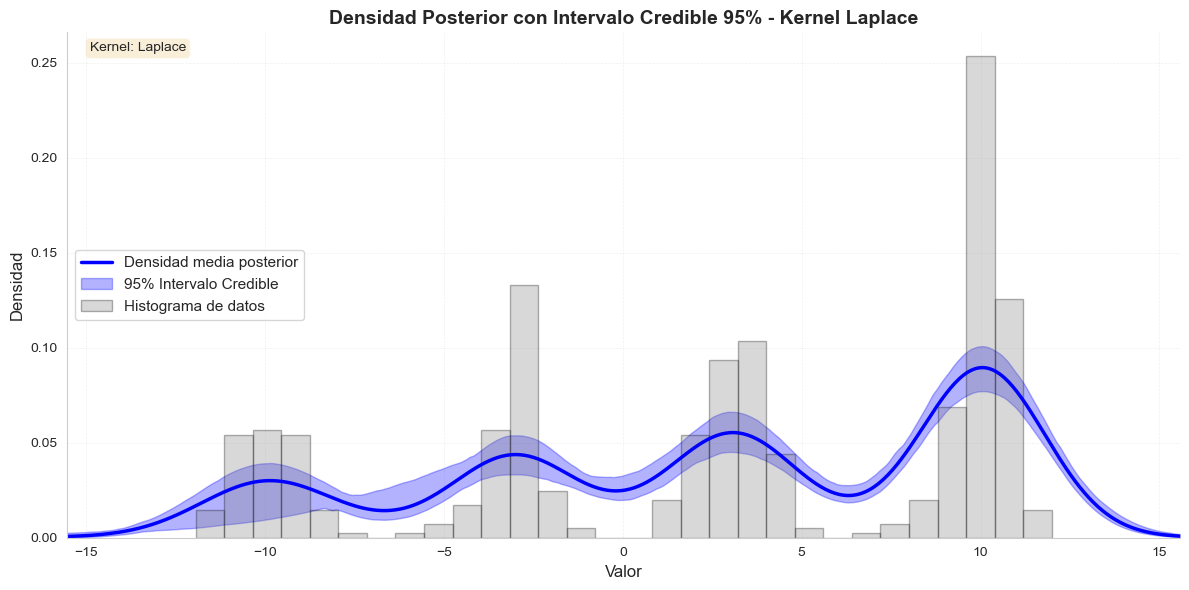

In [7]:
##################################################
# Graficos de intervalo de credibilidad 
##################################################
fig5_laplace = plot_density_credible_interval(
    trace=trace,
    y_data=datos['value'].values,
    kernel='laplace',
    burn_in=0,  # Ya aplicamos burnin
    n_posterior=2000,
    title="Densidad Posterior con Intervalo Credible 95% - Kernel Laplace",
    save_path=graphics_path / "credible_interval_laplace.png"
)